Based on:
- [https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html)
- [https://otexts.com/fpp2/expsmooth.html](https://otexts.com/fpp2/expsmooth.html)


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from data import load_raw_data, clean_raw_data, prepare_base_features, extract_ticker

In [53]:
df_raw = load_raw_data(rootpath = os.path.dirname(os.getcwd()))
df_clean = clean_raw_data(df_raw)
ticker = 'AAPL'
df_clean_ticker = extract_ticker(df_clean, ticker, requiredrecords=100, write=False) # datapath=datapat
df = prepare_base_features(df_clean_ticker)
df = df.sort_values('Date')

rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting
reading raw data from: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/world-stock-prices-daily-updating/World-Stock-Prices-Dataset.csv
Extracting for ticker: AAPL
Extracted sample shape: (100, 5)


In [ ]:
price = df['Close']
# convert the index to periods
price.index = price.index.to_period("D")
# price.index

## Simple Exponential Smoothing

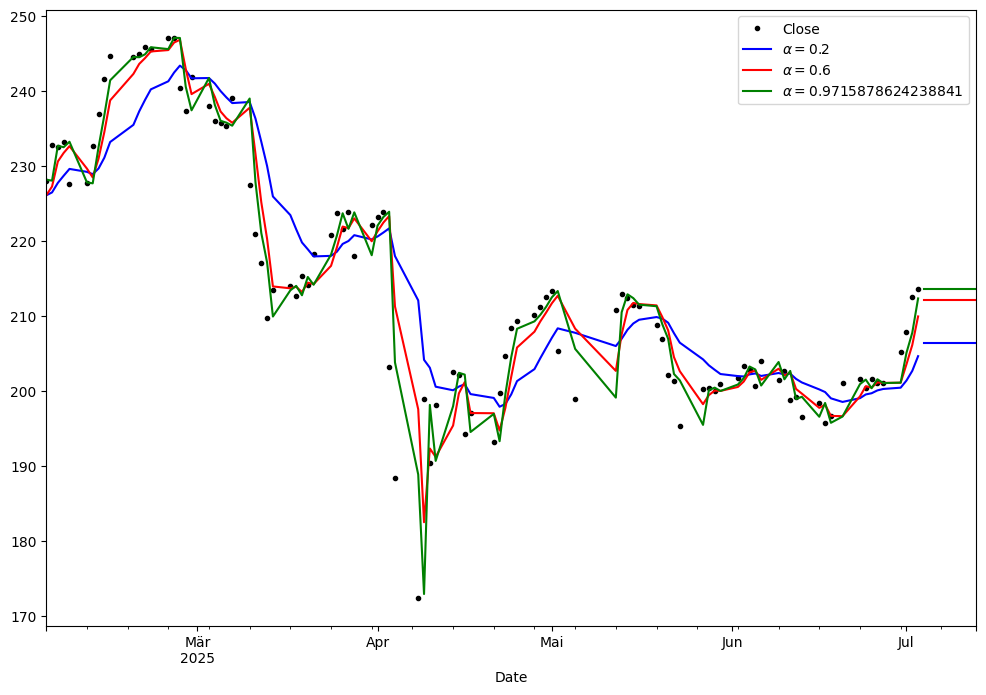

In [56]:

fit1 = SimpleExpSmoothing(price, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(10).rename(r"$\alpha=0.2$")

fit2 = SimpleExpSmoothing(price, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(10).rename(r"$\alpha=0.6$")

fit3 = SimpleExpSmoothing(price, initialization_method="estimated").fit()
fcast3 = fit3.forecast(10).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(12, 8))
price.plot(style='.',  color="black")
fit1.fittedvalues.plot(style='-', color="blue")
fcast1.plot(style='-', color="blue", label=fcast1.name)
fit2.fittedvalues.plot(style='-', color="red")
fcast2.plot(style='-', color="red", label=fcast2.name)
fit3.fittedvalues.plot(style='-', color="green")
fcast3.plot(style='-', color="green", label=fcast3.name)
plt.legend()

## Holt's Method

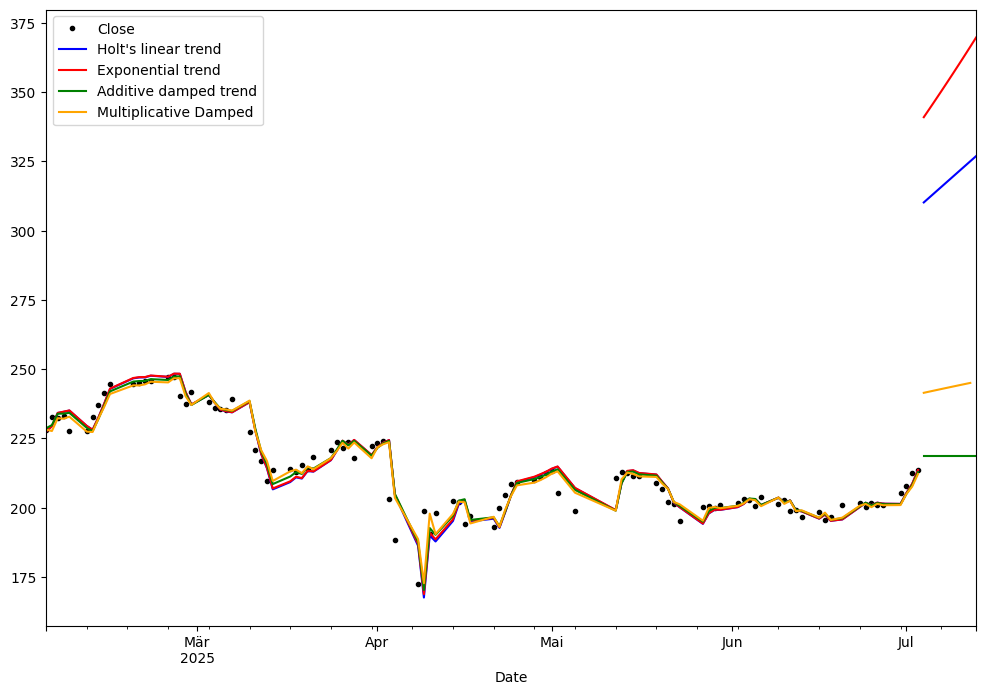

In [ ]:
fit1 = Holt(price, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(10).rename("Holt's linear trend")
fit2 = Holt(price, exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast2 = fit2.forecast(10).rename("Exponential trend")
fit3 = Holt(price, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
fcast3 = fit3.forecast(10).rename("Additive damped trend")

fit4 = Holt(
    price, exponential=True, damped_trend=True, initialization_method="estimated"
).fit()
fcast4 = fit4.forecast(9).rename("Multiplicative damped trend")

plt.figure(figsize=(12, 8))
price.plot(style='.',  color="black")
fit1.fittedvalues.plot(style='-', color="blue")
fcast1.plot(style='-', color="blue", label=fcast1.name)
fit2.fittedvalues.plot(style='-', color="red")
fcast2.plot(style='-', color="red", label=fcast2.name)
fit3.fittedvalues.plot(style='-', color="green")
fcast3.plot(style='-', color="green", label=fcast3.name)
plt.legend()
fit4.fittedvalues.plot(style='-', color="orange")
fcast4.plot(style='-', color="orange", label=fcast4.name)
plt.legend()

## Holt-Winter's Trend-Seasonal

In [ ]:
fit1 = ExponentialSmoothing(
    price,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    price,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit3 = ExponentialSmoothing(
    price,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit4 = ExponentialSmoothing(
    price,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["add-add"] = [fit1.params[p] for p in params] + [fit1.sse]
results["add-mult"] = [fit2.params[p] for p in params] + [fit2.sse]
results["add-add damp"] = [fit3.params[p] for p in params] + [fit3.sse]
results["add-mult damp"] = [fit4.params[p] for p in params] + [fit4.sse]

results

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,8.889286e-01,8.889286e-01,9.242857e-01,9.242857e-01
$\beta$,3.292328e-02,3.292328e-02,1.000000e-04,1.000000e-04
$\phi$,NaN,NaN,9.900000e-01,9.900000e-01
$\gamma$,3.702381e-02,3.702381e-02,3.244898e-02,3.244898e-02
$l_0$,5.840324e-01,5.840325e-01,5.840324e-01,5.840324e-01
$b_0$,5.245946e-08,-3.948875e-07,-2.886616e-07,-2.513017e-07
SSE,3.087336e+03,3.043078e+03,2.948703e+03,2.965764e+03


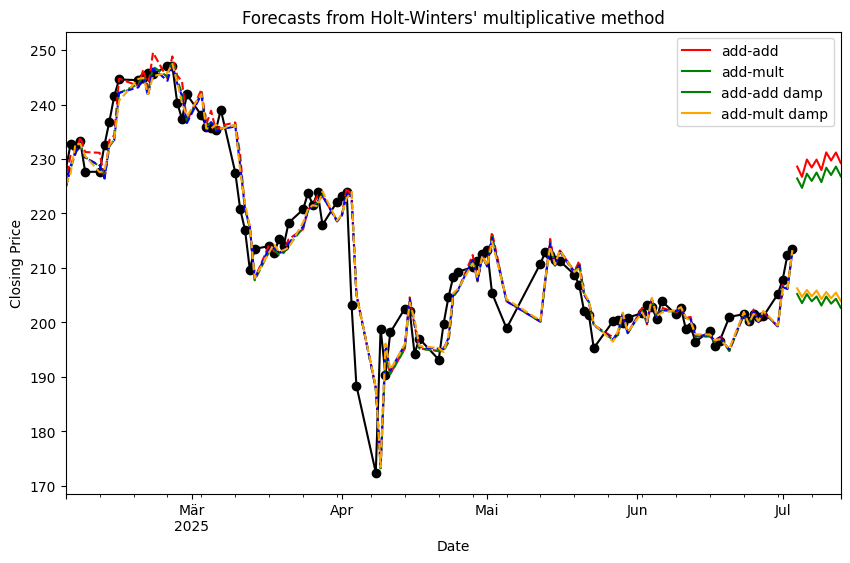

In [73]:
ax = price.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("Closing Price")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")
fit3.fittedvalues.plot(ax=ax, style="--", color="blue")
fit4.fittedvalues.plot(ax=ax, style="--", color="orange")

fit1.forecast(10).rename("add-add").plot(
    ax=ax, style="-", color="red", legend=True
)
fit2.forecast(10).rename("add-mult").plot(
    ax=ax, style="-", color="green", legend=True
)
fit3.forecast(10).rename("add-add damp").plot(
    ax=ax, style="-", color="green", legend=True
)
fit4.forecast(10).rename("add-mult damp").plot(
    ax=ax, style="-", color="orange", legend=True
)
plt.show()

## Confidence Intervals

In [70]:
price.index

PeriodIndex(['2025-02-03', '2025-02-04', '2025-02-05', '2025-02-06',
             '2025-02-07', '2025-02-10', '2025-02-11', '2025-02-12',
             '2025-02-13', '2025-02-14', '2025-02-18', '2025-02-19',
             '2025-02-20', '2025-02-21', '2025-02-24', '2025-02-25',
             '2025-02-26', '2025-02-27', '2025-02-28', '2025-03-03',
             '2025-03-04', '2025-03-05', '2025-03-06', '2025-03-07',
             '2025-03-10', '2025-03-11', '2025-03-12', '2025-03-13',
             '2025-03-14', '2025-03-17', '2025-03-18', '2025-03-19',
             '2025-03-20', '2025-03-21', '2025-03-24', '2025-03-25',
             '2025-03-26', '2025-03-27', '2025-03-28', '2025-03-31',
             '2025-04-01', '2025-04-02', '2025-04-03', '2025-04-04',
             '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11',
             '2025-04-14', '2025-04-15', '2025-04-16', '2025-04-17',
             '2025-04-21', '2025-04-22', '2025-04-23', '2025-04-24',
             '2025-04-25', '2025-0

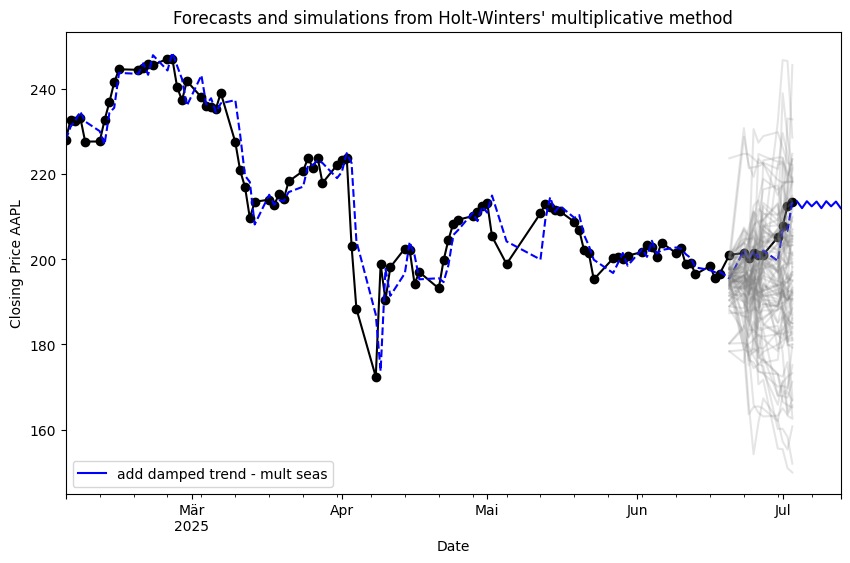

In [82]:

fit = ExponentialSmoothing(
    price,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    initialization_method="estimated",
).fit()
simulations = fit.simulate(
    10,
    anchor="2025-06-20",
    repetitions=100,
    error="mul",
    random_errors="bootstrap")

ax = price.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel(f"Closing Price {ticker}")
ax.set_xlabel("Year")
fit.fittedvalues.plot(ax=ax, style="--", color="blue")
simulations.plot(ax=ax, style="-", alpha=0.2, color="grey", legend=False)
fit.forecast(10).rename("add damped trend - mult seas").plot(
    ax=ax, style="-", color="blue", legend=True
)
plt.show()